In this workbook, I apply the Periodic Kernel to test case 19, variation 1, 3, 5, 7, 8. 

In [1]:
pwd

u'/home/riddhisw/Documents/2017/Scripts_Git'

In [2]:
import GPy, numpy as np 
from matplotlib import pyplot as plt
from gprtf.common import get_data

The optimisation problem over all 4 parameters for GPR is difficult. We link the periodicity and the lengthscale to the longest and shortest timescales of the system during training.

Namely:
    - p = N_train
    - l = 3 * Delta T 
    
Sigma (kernel / process noise variance) and R (Kalman msmt noise variance) orders were estimated from optimisation during Kalman filtering. 

We note that if the optimal periodicity >> N_train or N, the algorithm tends to pick l <<< Delta T, and a failure results.

We recreate this failure by constraining periodicity a small distance away from n_train.

Test Case 7, 1 (Four Fourier Components) and Test Case 19, 1 (Severely Undersampled 'White' Noise with 1% SNR) with the following parameters:

    - n_train = 2000
    - Delta_T = 0.001
    - sigma = 1.0
    - R =  1.0
    - SigmaMax = 1000.0 
    - Rmax = 30.0

We then confirm that the procedure to narrow the optimisation problem (as above) works by:

    - Case A: unconstrained Periodicity
    - Case B: m1.std_periodic.period.constrain_bounded(1970, 1971)
    - Case C: m1.std_periodic.period.constrain_bounded(2075, 2076)

In [3]:
test_case = 19
variation = 1
n_train = 2000
Delta_T = 0.001
sigma = 1.0
R =  1.0
SigmaMax = 1000.0 # tc 7 var 1, sigma = 1000.0
Rmax = 30.0
# sigma and periodicity move together.
# unconstrained == periodicity --> infinity, sigma --> large, predictions -->zero
# failure = increasing periodicity (algorithm appears to be predicting zero)

In [4]:
x, y, testx, truth, n_predict= get_data(test_case, variation, randomize='n')
num = truth.shape[0]
X = x[0:n_train,np.newaxis]
Y = y[0:n_train,np.newaxis]
f_0 = 1.0/n_train #num
w_0 = 2.0*np.pi*f_0
period = 2.0*np.pi / w_0
print period
print num == n_predict + n_train

('Shapes', 2000, 2000, (150,))
2000.0
True


In [5]:
kern5 = GPy.kern.StdPeriodic(1, period=period, variance=sigma, lengthscale=3*Delta_T )

In [6]:
gauss = GPy.likelihoods.Gaussian(variance=R)
exact = GPy.inference.latent_function_inference.ExactGaussianInference()
m1 = GPy.core.GP(X=X, Y=Y, kernel=kern5, likelihood=gauss, inference_method=exact)
print m1


Name : gp
Objective : 108624980.094
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |  constraints  |  priors
  std_periodic.variance     |     1.0  |      +ve      |        
  std_periodic.period       |  2000.0  |      +ve      |        
  std_periodic.lengthscale  |   0.003  |      +ve      |        
  Gaussian_noise.variance   |     1.0  |      +ve      |        


k(x,y) = \theta_1 \exp \left[  - \frac{1}{2} \sum_{i=1}^{input\_dim}
   \left( \frac{\sin(\frac{\pi}{T_i} (x_i - y_i) )}{l_i} \right)^2 \right] }

In [7]:
m1.std_periodic.variance.constrain_bounded(0, SigmaMax)
m1.Gaussian_noise.variance.constrain_bounded(0, Rmax)
m1.std_periodic.period.constrain_bounded(2075, 2076)
print(m1)


Name : gp
Objective : 105462623.411
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |   0.0,1000.0    |        
  std_periodic.period       |  2075.5  |  2075.0,2076.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.variance   |     1.0  |    0.0,30.0     |        



Name : gp
Objective : 88019.9550674
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |             value  |   constraints   |  priors
  std_periodic.variance     |     999.999880172  |   0.0,1000.0    |        
  std_periodic.period       |     2075.50320408  |  2075.0,2076.0  |        
  std_periodic.lengthscale  |  0.00861916038515  |       +ve       |        
  Gaussian_noise.variance   |     29.9999925637  |    0.0,30.0     |        


 /home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


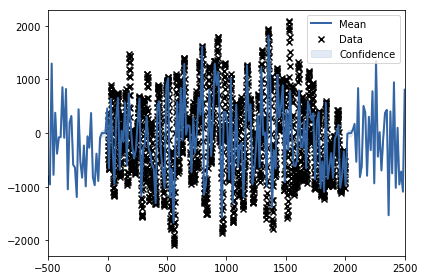

In [8]:
m1.optimize(messages=1, ipython_notebook=True)
_ = m1.plot()
print m1
plt.show()

In [9]:
predictions = m1.predict(testx[:,np.newaxis])[0].flatten()

In [10]:
plt.figure(figsize=(10,5))
plt.plot(testx, predictions, 'go', alpha=0.5, label='Predictions')
plt.plot(testx, truth[n_train-50:], 'r', label='Truth')
plt.plot(x[n_train-50:n_train], y[n_train-50:n_train], 'kx', label='Msmts')
plt.legend(loc=0)
plt.title('GPy PRE, Testcase %s Var %s RMax %s SigMax %s' %(test_case, variation, Rmax, SigmaMax))
plt.savefig('Gpy_PER_try2_tc_'+str(test_case)+'_var_'+str(variation))
plt.close()